In [50]:
def estimate_fakeness_score(prev_points, next_points, status, frame_shape, weights=(0.6, 0.4)):
    '''Compute a normalized fakeness score from raw tracking data.'''
    try:
        distortion = compute_homography_distortion(prev_points, next_points, frame_shape)
        mask = np.zeros((np.sum(status), 1), dtype=np.uint8)
        bg_drift = background_motion_score(prev_points, next_points, status, mask)

        flow = next_points[status == 1] - prev_points[status == 1]
        motion = np.mean(np.linalg.norm(flow, axis=1)) + 1e-6

        dist_norm = distortion / motion
        drift_norm = bg_drift / motion

        score = weights[0] * dist_norm + weights[1] * drift_norm
        return min(score, 1.5)
    except Exception as e:
        print("⚠️ Fakeness score error:", e)
        return 0.0


In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# YOLO class definitions
dynamic_classes = {"person", "car", "bicycle", "dog", "cat", "ball", "motorbike", "truck", "bus"}
static_classes = {"chair", "table", "bench", "bed", "refrigerator", "pottedplant", "toilet", "sofa"}

# Optical flow parameters
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Load YOLOv3 model
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Initialize video and data structures
cap = cv2.VideoCapture("room.mp4mp4")
prev_gray = None
prev_points = None
heatmap = np.zeros((480, 640), dtype=np.float32)
moving_points_over_time = []
# Up to 100 separate tracked point histories
moving_point_trajectories = [[] for _ in range(100)]
fakeness_scores = []

# ========== Define helper functions ==========

def compute_homography_distortion(prev_points, next_points, frame_shape):
    status = np.ones(prev_points.shape[0], dtype=bool)
    valid_prev = prev_points[status]
    valid_next = next_points[status]
    if len(valid_prev) < 4:
        return 0
    H, _ = cv2.findHomography(valid_prev, valid_next, cv2.RANSAC)
    if H is None:
        return 0
    prev_pts_homog = cv2.perspectiveTransform(valid_prev.reshape(-1, 1, 2), H).reshape(-1, 2)
    diffs = np.linalg.norm(prev_pts_homog - valid_next, axis=1)
    avg_distortion = np.mean(diffs)
    h, w = frame_shape[:2]
    return avg_distortion / np.sqrt(h**2 + w**2)

def background_motion_score(prev_points, next_points, status, mask, motion_threshold=0.5):
    if status is None or mask is None:
        return 0
    prev_valid = prev_points[status.ravel() == 1]
    next_valid = next_points[status.ravel() == 1]
    mask_valid = mask.ravel() == 0
    bg_prev = prev_valid[mask_valid]
    bg_next = next_valid[mask_valid]
    if len(bg_prev) == 0:
        return 0
    displacement = np.linalg.norm(bg_next - bg_prev, axis=1)
    return np.mean(displacement)


OpenCV: Couldn't read video stream from file "room.mp4mp4"


If distortion or background_drift spike abnormally high (e.g., due to noise), your raw score could exceed 1.0. 
Capping it with min(score, 1.0) ensures it stays within a meaningful scale.

In [52]:
# ===== Load YOLO model =====
import cv2

# Paths to YOLO model files (adjust if needed)
yolo_weights = "yolov3.weights"       # or yolov4.weights
yolo_cfg = "yolov3.cfg"               # or yolov4.cfg


# Load YOLO
net = cv2.dnn.readNet(yolo_weights, yolo_cfg)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]



coco_classes = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [53]:
import cv2
import numpy as np

# Load video
cap = cv2.VideoCapture("room.mp4")
if not cap.isOpened():
    raise IOError("❌ Cannot open video file.")

# Initialize tracking variables
feature_params = dict(maxCorners=200, qualityLevel=0.01, minDistance=5, blockSize=7)

moving_points_over_time = []
moving_point_trajectories = []
fakeness_scores = []
heatmap = np.zeros((int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))), dtype=np.float32)

first_valid_frame = None
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if first_valid_frame is None:
        first_valid_frame = frame.copy()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_count += 1

    # ===== YOLO Object Detection (safe version) =====
    if frame is not None:
        blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        net.setInput(blob)
        outs = net.forward(output_layers)

        boxes = []
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * frame.shape[1])
                    center_y = int(detection[1] * frame.shape[0])
                    w = int(detection[2] * frame.shape[1])
                    h = int(detection[3] * frame.shape[0])
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    label = coco_classes[class_id]
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
                    cv2.putText(frame, str(label), (x, y + 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        print("⚠️ Skipping YOLO detection: frame is None")

    # ===== Optical Flow + Homography Tracking =====
    if 'prev_points' in locals() and prev_points is not None:
        next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_points, None)
        valid_points = next_points[status == 1]
        prev_valid_points = prev_points[status == 1]
        moved_points = []

        for new, old in zip(valid_points, prev_valid_points):
            a, b = new.ravel()
            c, d = old.ravel()
            movement = np.linalg.norm([a - c, b - d])
            if movement > 2:
                moved_points.append((a, b))
                moving_points_over_time.append((a, b))
                cv2.circle(frame, (int(a), int(b)), 3, (0, 0, 255), 2)
            else:
                cv2.circle(frame, (int(a), int(b)), 2, (255, 255, 255), -1)

        for new, old in zip(valid_points, prev_valid_points):
            a, b = new.ravel().astype(int)
            c, d = old.ravel().astype(int)
            frame = cv2.line(frame, (a, b), (c, d), (0, 255, 0), 1)

        if len(valid_points) >= 4:
            H, _ = cv2.findHomography(prev_valid_points, valid_points, cv2.RANSAC)
            try:
                prev_valid_points = prev_valid_points.reshape(-1, 2).astype(np.float32)
                if H is not None and H.shape == (3, 3):
                    projected_prev = cv2.perspectiveTransform(prev_valid_points[:, np.newaxis], H).reshape(-1, 2)
                    min_len = min(len(valid_points), len(projected_prev))
                    inconsistencies = np.linalg.norm(valid_points[:min_len] - projected_prev[:min_len], axis=1)

                    for pt, err in zip(valid_points[:min_len], inconsistencies):
                        x, y = pt.ravel().astype(int)
                        if 0 <= y < heatmap.shape[0] and 0 <= x < heatmap.shape[1]:
                            heatmap[y, x] += err
                            if err > 3:
                                cv2.circle(frame, (x, y), 5, (255, 0, 255), 1)
            except Exception as e:
                print(f"⚠️ perspectiveTransform failed: {e}")

        if frame_count > 1:
            try:
                score = estimate_fakeness_score(prev_points, next_points, status, frame.shape)
                fakeness_scores.append(score)
            except Exception as e:
                print("⚠️ Fakeness computation error:", e)

        for i, (a, b) in enumerate(valid_points):
            if i < len(moving_point_trajectories):
                moving_point_trajectories[i].append((a, b))

    prev_points = cv2.goodFeaturesToTrack(gray, mask=None, **feature_params)
    prev_gray = gray.copy()
    last_valid_frame = frame.copy()

    cv2.imshow("Frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

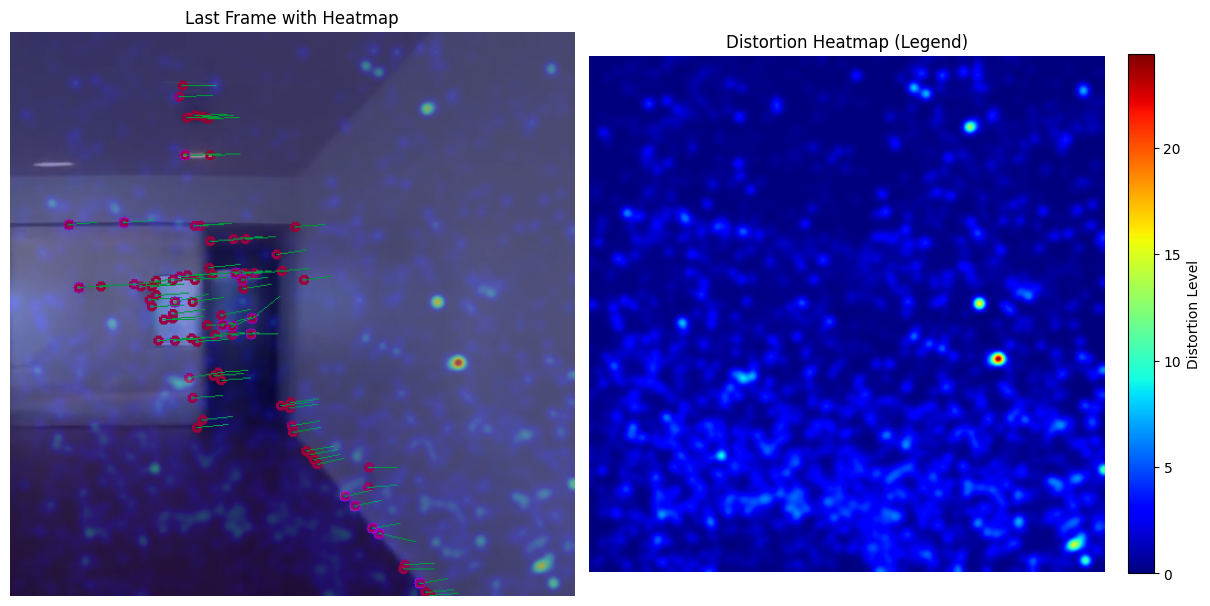

In [54]:
# ========== Overlay motion heatmap ==========
import matplotlib.pyplot as plt

# Blur and normalize heatmap
heatmap_blurred = cv2.GaussianBlur(heatmap, (25, 25), 0)
heatmap_norm = cv2.normalize(heatmap_blurred, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
heatmap_color = cv2.resize(heatmap_color, (last_valid_frame.shape[1], last_valid_frame.shape[0]))
overlay_l = cv2.addWeighted(last_valid_frame, 0.6, heatmap_color, 0.4, 0)
overlay_f = cv2.addWeighted(first_valid_frame, 0.6, heatmap_color, 0.4, 0)

# Convert BGR to RGB for matplotlib
f_frame_rgb = cv2.cvtColor(first_valid_frame, cv2.COLOR_BGR2RGB)
l_frame_rgb = cv2.cvtColor(last_valid_frame, cv2.COLOR_BGR2RGB)
overlay_rgb_f = cv2.cvtColor(overlay_f, cv2.COLOR_BGR2RGB)
overlay_rgb_l = cv2.cvtColor(overlay_l, cv2.COLOR_BGR2RGB)

# Show overlays and heatmap with colorbar
plt.figure(figsize=(18, 6))

# First frame overlay

# Last frame overlay
plt.subplot(1, 3, 2)
plt.imshow(overlay_rgb_l)
plt.title("Last Frame with Heatmap")
plt.axis("off")

# Heatmap for colorbar
plt.subplot(1, 3, 3)
# Show the raw grayscale heatmap for correct colorbar mapping
im = plt.imshow(heatmap_blurred, cmap='jet')
plt.title("Distortion Heatmap (Legend)")
plt.axis("off")
plt.colorbar(im, fraction=0.046, pad=0.04, label='Distortion Level')

plt.tight_layout()
plt.show()

cv2.imshow("Overlayed Heatmap", overlay_rgb_l)


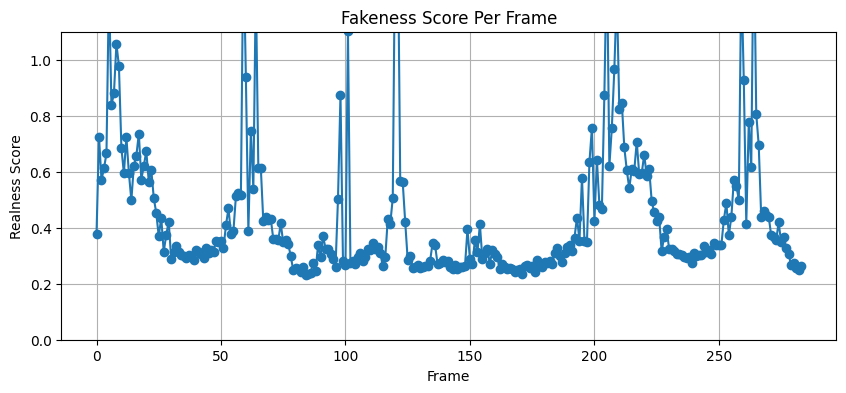

In [55]:
# ========== Plot fakeness score ==========
if fakeness_scores:
    plt.figure(figsize=(10, 4))
    plt.plot(fakeness_scores, marker='o')
    plt.title("Fakeness Score Per Frame")
    plt.xlabel("Frame")
    plt.ylabel("Realness Score")
    plt.ylim(0, 1.1)
    plt.grid(True)
    plt.show()
else:
    print("No fakeness scores to plot.")


In [56]:
def compute_homography_distortion(prev_points, next_points, frame_shape):
    '''Estimate how much the homography deviates from identity (ideal camera motion)'''
    status = np.ones(prev_points.shape[0], dtype=bool)
    valid_prev = prev_points[status]
    valid_next = next_points[status]

    if len(valid_prev) < 4:
        return 0  # Not enough points

    H, mask = cv2.findHomography(valid_prev, valid_next, cv2.RANSAC)
    if H is None:
        return 0

    # Apply homography to previous points
    prev_pts_homog = cv2.perspectiveTransform(valid_prev.reshape(-1, 1, 2), H)
    prev_pts_homog = prev_pts_homog.reshape(-1, 2)

    # Distortion = average displacement between actual next_points and warped previous points
    diffs = np.linalg.norm(prev_pts_homog - valid_next, axis=1)
    avg_distortion = np.mean(diffs)

    # Normalize by image diagonal length for scale invariance
    h, w = frame_shape[:2]
    norm_factor = np.sqrt(h**2 + w**2)
    return avg_distortion / norm_factor


In [57]:
def background_motion_score(prev_points, next_points, status, mask, motion_threshold=1.5):
    '''Compute average motion magnitude for background points (mask == 0)'''
    if status is None or mask is None:
        return 0

    prev_valid = prev_points[status.ravel() == 1]
    next_valid = next_points[status.ravel() == 1]
    mask_valid = mask.ravel() == 0  # points classified as background

    bg_prev = prev_valid[mask_valid]
    bg_next = next_valid[mask_valid]

    if len(bg_prev) == 0:
        return 0

    displacement = np.linalg.norm(bg_next - bg_prev, axis=1)
    return np.mean(displacement)


In [58]:
fakeness_scores = []

# Inside your frame loop, after computing homography and optical flow:
# (Make sure you define next_points, prev_points, and have access to frame shape)

if prev_points is not None and next_points is not None:
    try:
        # Compute homography distortion
        distortion = compute_homography_distortion(prev_points, next_points, frame.shape)

        # Simulated background mask (assume all points are background for now)
        mask = np.zeros((prev_points.shape[0], 1), dtype=np.uint8)

        # Compute background drift score
        bg_drift = background_motion_score(prev_points, next_points, status, mask)

        # Combine into fakeness score
        fake_score = estimate_fakeness_score(distortion, bg_drift)

        fakeness_scores.append(fake_score)

        print(f"Frame {len(fakeness_scores)} → Homography Distortion: {distortion:.4f}, Background Drift: {bg_drift:.4f}, Fake Score: {fake_score:.4f}")
    except Exception as e:
        print(f"Fakeness computation error: {e}")


Fakeness computation error: 'NoneType' object has no attribute 'shape'


In [59]:
# Plot fakeness score across all frames
if fakeness_scores:
    plt.figure(figsize=(10, 4))
    plt.plot(fakeness_scores, marker='o')
    plt.title("Estimated Fakeness Score Per Frame")
    plt.xlabel("Frame")
    plt.ylabel("Fakeness Score (0 = Real, 1 = Suspicious)")
    plt.ylim(0, 1.1)
    plt.grid(True)
    plt.show()


In [60]:
# Compute fakeness score inside video processing loop (after optical flow and before updating prev points)
if frame is not None and prev_points is not None and next_points is not None:
    try:
        distortion = compute_homography_distortion(prev_points, next_points, frame.shape)
        mask = np.zeros((prev_points.shape[0], 1), dtype=np.uint8)  # Assume all background
        bg_drift = background_motion_score(prev_points, next_points, status, mask)
        fake_score = estimate_fakeness_score(distortion, bg_drift)
        fakeness_scores.append(fake_score)

        print(f"Frame {len(fakeness_scores)}: Distortion={distortion:.4f}, Drift={bg_drift:.4f}, Score={fake_score:.4f}")
    except Exception as e:
        print("Fakeness computation error:", e)


In [61]:
# Compute temporal consistency score using RANSAC (inside your frame loop after optical flow)

temporal_consistency_score = 0.0
temporal_inliers = 0
temporal_outliers = 0

if prev_points is not None and next_points is not None and len(prev_points) >= 4:
    try:
        # Use RANSAC to separate consistent vs inconsistent motion
        H, inlier_mask = cv2.findHomography(prev_valid_points, valid_points, cv2.RANSAC, 3.0)

        inlier_mask = inlier_mask.ravel() if inlier_mask is not None else np.ones(len(valid_points), dtype=np.uint8)

        temporal_inliers = np.sum(inlier_mask)
        temporal_outliers = len(inlier_mask) - temporal_inliers

        # Score: 0 = all consistent, 1 = all inconsistent
        temporal_consistency_score = 1.0 - (temporal_inliers / len(inlier_mask))
        print(f"Temporal Consistency Score: {temporal_consistency_score:.3f} ({temporal_outliers} outliers)")

        # Visualization
        for i, pt in enumerate(valid_points):
            color = (0, 255, 0) if inlier_mask[i] else (0, 0, 255)
            cv2.circle(frame, (int(pt[0]), int(pt[1])), 4 if inlier_mask[i] else 6, color, -1 if inlier_mask[i] else 2)

    except Exception as e:
        print("Temporal consistency error:", e)


Temporal Consistency Score: 0.241 (20.0 outliers)


In [62]:
# ===== Object-wise Homography Distortion Aggregation =====
objects = []  # Store object-level data

# Safeguard: skip if frame is invalid
if frame is None:
    print("⚠️ Warning: 'frame' is None. Skipping object detection.")
else:
    height, width = frame.shape[:2]

    # YOLO detection loop (assumes `outs` and `coco_classes` are defined)
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                label = coco_classes[class_id]

                # Record box and object metadata
                boxes.append([x, y, w, h])
                objects.append({
                    "label": label,
                    "bbox": (x, y, x + w, y + h),
                    "distortion": 0.0,
                    "count": 0
                })

                # Draw bounding box and label
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
                cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.6, (255, 255, 255), 2)

# ===== Homography inconsistency aggregation per object =====
if frame is not None and len(valid_points) >= 4:
    H, _ = cv2.findHomography(prev_valid_points, valid_points, cv2.RANSAC)
    if H is not None:
        projected_prev = cv2.perspectiveTransform(prev_valid_points.reshape(-1, 1, 2), H).reshape(-1, 2)
        inconsistencies = np.linalg.norm(valid_points - projected_prev, axis=1)

        # Assign inconsistency error to objects by bounding box
        for pt, err in zip(valid_points, inconsistencies):
            x, y = pt.ravel()
            for obj in objects:
                x1, y1, x2, y2 = obj["bbox"]
                if x1 <= x <= x2 and y1 <= y <= y2:
                    obj["distortion"] += err
                    obj["count"] += 1
                    break

        # Annotate objects with their average distortion score
        for obj in objects:
            if obj["count"] > 0:
                avg_dist = obj["distortion"] / obj["count"]
                x1, y1, x2, y2 = obj["bbox"]
                cv2.putText(frame, f"{avg_dist:.1f}", (x1, y2 + 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)


⚠️ Warning: 'frame' is None. Skipping object detection.


In [63]:
# ====== Save MP4 Video with Bounding Boxes, Labels, and Tracked Motion ======
import cv2
import numpy as np

output_path = "output_tracked_video.mp4"
fps = 20

cap = cv2.VideoCapture("room.mp4")
if not cap.isOpened():
    raise IOError("❌ Cannot open video file.")

ret, first_frame = cap.read()
if not ret or first_frame is None:
    raise ValueError("❌ Failed to read the first frame.")

height, width = first_frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
prev_points = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
moving_points_over_time = []
moving_point_trajectories = [[] for _ in range(len(prev_points))] if prev_points is not None else []
fakeness_scores = []
heatmap = np.zeros((height, width), dtype=np.float32)

frame_count = 1
last_valid_frame = first_frame.copy()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame is None:
        print("⚠️ End of video or failed frame read.")
        break

    if frame.shape[:2] != (height, width):
        frame = cv2.resize(frame, (width, height))

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Dummy detection results (replace with actual detection)
    boxes = []   # [(x1, y1, x2, y2)]
    labels = []  # ["person", "car", ...]

    for (x1, y1, x2, y2), label in zip(boxes, labels):
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 255), 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (255, 255, 255), 2)

    if prev_points is not None:
        next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_points, None)
        valid_points = next_points[status == 1]
        prev_valid_points = prev_points[status == 1]
        moved_points = []

        for new, old in zip(valid_points, prev_valid_points):
            a, b = new.ravel()
            c, d = old.ravel()
            movement = np.linalg.norm([a - c, b - d])
            if movement > 2:
                moved_points.append((a, b))
                moving_points_over_time.append((a, b))
                cv2.circle(frame, (int(a), int(b)), 3, (0, 0, 255), 2)
            else:
                cv2.circle(frame, (int(a), int(b)), 2, (255, 255, 255), -1)

        for new, old in zip(valid_points, prev_valid_points):
            a, b = new.ravel().astype(int)
            c, d = old.ravel().astype(int)
            cv2.line(frame, (a, b), (c, d), (0, 255, 0), 1)

        if len(valid_points) >= 4:
            H, _ = cv2.findHomography(prev_valid_points, valid_points, cv2.RANSAC)
            if prev_valid_points is not None and len(prev_valid_points) >= 4:
                try:
                    prev_valid_points = prev_valid_points.reshape(-1, 2).astype(np.float32)
                    if H is not None and H.shape == (3, 3):
                        projected_prev = cv2.perspectiveTransform(prev_valid_points[:, np.newaxis], H).reshape(-1, 2)
                        inconsistencies = np.linalg.norm(valid_points - projected_prev, axis=1)

                        for pt, err in zip(valid_points, inconsistencies):
                            x, y = pt.ravel().astype(int)
                            if 0 <= y < heatmap.shape[0] and 0 <= x < heatmap.shape[1]:
                                heatmap[y, x] += err
                                if err > 3:
                                    cv2.circle(frame, (x, y), 5, (255, 0, 255), 1)
                except Exception as e:
                    print(f"⚠️ perspectiveTransform failed: {e}")

        if frame_count > 1:
            try:
                score = estimate_fakeness_score(prev_points, next_points, status, frame.shape)
                fakeness_scores.append(score)
            except Exception as e:
                print("⚠️ Fakeness computation error:", e)

        for i, (a, b) in enumerate(valid_points):
            if i < len(moving_point_trajectories):
                moving_point_trajectories[i].append((a, b))

    prev_points = cv2.goodFeaturesToTrack(gray, mask=None, **feature_params)
    prev_gray = gray.copy()
    last_valid_frame = frame.copy()

    video_writer.write(frame)
    frame_count += 1

    cv2.imshow("Frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
video_writer.release()
cv2.destroyAllWindows()
print(f"✅ Saved {frame_count} frames to {output_path}")


⚠️ End of video or failed frame read.
✅ Saved 285 frames to output_tracked_video.mp4


In [64]:
print(estimate_fakeness_score.__code__.co_varnames)


('prev_points', 'next_points', 'status', 'frame_shape', 'weights', 'distortion', 'mask', 'bg_drift', 'flow', 'motion', 'dist_norm', 'drift_norm', 'score', 'e')
